In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 2
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [18]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [26]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [27]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [28]:
train_sgd=False
num_epochs=100
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_softmax.pdf', bbox_inches='tight')
    model.net.save_parameters('softmax_sgd_'+str(num_epochs)+'_epochs.params')
else:
    model.net.load_parameters('softmax_sgd_'+str(num_epochs)+'_epochs.params',ctx=model_ctx)
    par=dict()
    for name,gluon_par in model.net.collect_params().items():
        par.update({name:gluon_par.data()})
               


In [30]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=10,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       979
           1       0.97      0.97      0.97      1133
           2       0.92      0.88      0.90      1030
           3       0.89      0.89      0.89      1008
           4       0.88      0.92      0.90       980
           5       0.83      0.86      0.85       890
           6       0.89      0.93      0.91       956
           7       0.91      0.91      0.91      1027
           8       0.85      0.84      0.85       973
           9       0.93      0.85      0.89      1008

    accuracy                           0.90      9984
   macro avg       0.90      0.90      0.90      9984
weighted avg       0.91      0.90      0.90      9984



In [31]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [84]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [85]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=False
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='chain_nonhierarchical')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_softmax.pdf', bbox_inches='tight')
else:
    chain1=glob.glob("../scripts/results/softmax/chain_nonhierarchical_0_1_sgld*")
    chain2=glob.glob("../scripts/results/softmax/chain_nonhierarchical_0_sgld*")
    posterior_samples=[chain1,chain2]

In [87]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [88]:
total_samples,total_labels,log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [89]:
from sklearn.metrics import classification_report

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.89      0.90      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.86      0.88      0.87       892
           6       0.94      0.95      0.95       958
           7       0.92      0.93      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [92]:
import arviz as az

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [79]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"1.weight[0,0]",-0.496,1.478,-2.993,1.342,0.867,0.687,3.0,60.0,1.83
"1.weight[0,1]",-2.072,0.963,-3.561,-0.288,0.078,0.056,151.0,132.0,1.18
"1.weight[0,2]",-2.137,0.704,-3.061,-0.540,0.149,0.147,11.0,62.0,1.14
"1.weight[0,3]",-0.169,0.714,-1.563,1.093,0.158,0.144,59.0,222.0,1.13
"1.weight[0,4]",0.265,0.833,-1.162,1.501,0.511,0.411,3.0,107.0,1.83
...,...,...,...,...,...,...,...,...,...
1.bias[5],3.268,0.810,1.617,4.547,0.283,0.239,5.0,98.0,1.32
1.bias[6],0.029,0.477,-0.916,0.814,0.038,0.027,143.0,74.0,1.03
1.bias[7],1.688,0.464,0.899,2.364,0.045,0.032,161.0,47.0,1.12
1.bias[8],-2.649,0.514,-3.663,-1.877,0.054,0.038,97.0,136.0,1.06


In [80]:
print(mean_r_hat_values)

{'1.weight': 1.453861862862687, '1.bias': 1.1607318528841408}


In [81]:
mean_ess_values

{'1.weight': 30.12714771000977, '1.bias': 64.02426545788761}

In [82]:
mean_mcse_values

{'1.weight': 0.4712754299075291, '1.bias': 0.13311773795785092}

In [118]:
from hamiltonian.psis import *

loo,loos,ks=psisloo(log_like)

In [112]:
ks[ks>1]=1

<AxesSubplot:ylabel='Count'>

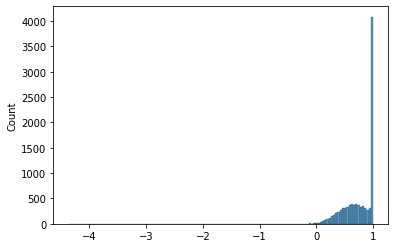

In [113]:
sns.histplot(ks)

In [99]:
np.sum(ks>0.7)

6286

# Hierarchical Softmax <a class="anchor" id="chapter3"></a>

In [119]:
from hamiltonian.models.softmax import hierarchical_softmax
from hamiltonian.inference.sgld import sgld

model=hierarchical_softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [120]:
train_sgld=False
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='chain_hierarchical')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_softmax.pdf', bbox_inches='tight')
else:
    chain1=glob.glob("../scripts/results/softmax/chain_hierarchical_0_1_sgld*")
    chain2=glob.glob("../scripts/results/softmax/chain_hierarchical_0_sgld*")
    posterior_samples=[chain1,chain2]

In [121]:
total_samples,total_labels,log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [122]:
from sklearn.metrics import classification_report

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.98      0.97      0.98      1135
           2       0.93      0.90      0.91      1032
           3       0.89      0.90      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.86      0.87      0.87       892
           6       0.92      0.94      0.93       958
           7       0.91      0.93      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [123]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [124]:
import arviz as az

datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")

In [125]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"1.weight[0,0]",-0.496,1.478,-2.993,1.342,0.867,0.687,3.0,60.0,1.83
"1.weight[0,1]",-2.072,0.963,-3.561,-0.288,0.078,0.056,151.0,132.0,1.18
"1.weight[0,2]",-2.137,0.704,-3.061,-0.540,0.149,0.147,11.0,62.0,1.14
"1.weight[0,3]",-0.169,0.714,-1.563,1.093,0.158,0.144,59.0,222.0,1.13
"1.weight[0,4]",0.265,0.833,-1.162,1.501,0.511,0.411,3.0,107.0,1.83
...,...,...,...,...,...,...,...,...,...
1.bias[5],3.268,0.810,1.617,4.547,0.283,0.239,5.0,98.0,1.32
1.bias[6],0.029,0.477,-0.916,0.814,0.038,0.027,143.0,74.0,1.03
1.bias[7],1.688,0.464,0.899,2.364,0.045,0.032,161.0,47.0,1.12
1.bias[8],-2.649,0.514,-3.663,-1.877,0.054,0.038,97.0,136.0,1.06


In [126]:
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
print(mean_r_hat_values)

{'1.weight': 1.453861862862687, '1.bias': 1.1607318528841408}


In [127]:
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
print(mean_ess_values)

{'1.weight': 30.12714771000977, '1.bias': 64.02426545788761}


In [128]:
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}
print(mean_mcse_values)

{'1.weight': 0.4712754299075291, '1.bias': 0.13311773795785092}


In [129]:
loo,loos,ks=psisloo(log_like)

In [132]:
np.sum(ks>0.7)

6273

<AxesSubplot:ylabel='Count'>

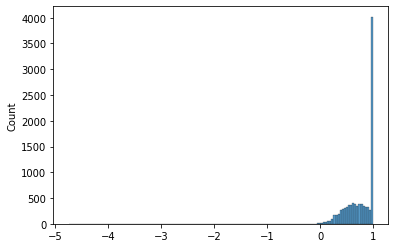

In [134]:
ks[ks>1]=1
sns.histplot(ks)